In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import year, month
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("GOTOStockPricePrediction") \
    .getOrCreate()

In [4]:
df = spark.read.csv(r"C:\Users\ASUS\Documents\proyek machine learning\projek 2\GOTO.JK.csv", header=True, inferSchema=True)
df.show(5)

+----------+-----+-----+-----+-----+---------+---------+
|      Date| Open| High|  Low|Close|Adj Close|   Volume|
+----------+-----+-----+-----+-----+---------+---------+
|2022-12-05|123.0|123.0|123.0|123.0|    123.0|172815100|
|2022-12-06|115.0|115.0|115.0|115.0|    115.0|188696800|
|2022-12-07|107.0|107.0|107.0|107.0|    107.0|248475200|
|2022-12-08|100.0|100.0|100.0|100.0|    100.0|482718800|
|2022-12-09| 93.0| 93.0| 93.0| 93.0|     93.0|280769900|
+----------+-----+-----+-----+-----+---------+---------+
only showing top 5 rows



In [5]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)



In [6]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+
|summary|              Open|             High|               Low|             Close|         Adj Close|              Volume|
+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+
|  count|               379|              379|               379|               379|               379|                 379|
|   mean| 90.69920844327177|92.94986807387863| 88.29023746701847| 90.51715039577836| 90.51715039577836|3.9450453089709764E9|
| stddev|21.133470391782584|21.64871341005261|20.724833267474626|21.339200490471974|21.339200490471974| 5.438893406166314E9|
|    min|              50.0|             50.0|              50.0|              50.0|              50.0|                   0|
|    max|             131.0|            147.0|             128.0|             147.0|             147.0|         66010808800|


In [7]:
df = df.withColumn("date", to_date(unix_timestamp(col("date"), "yyyy-MM-dd").cast("timestamp")))
df = df.withColumn("year", year(col("date"))).withColumn("month", month(col("date")))

# Menampilkan beberapa baris data setelah transformasi
df.show(5)

+----------+-----+-----+-----+-----+---------+---------+----+-----+
|      date| Open| High|  Low|Close|Adj Close|   Volume|year|month|
+----------+-----+-----+-----+-----+---------+---------+----+-----+
|2022-12-05|123.0|123.0|123.0|123.0|    123.0|172815100|2022|   12|
|2022-12-06|115.0|115.0|115.0|115.0|    115.0|188696800|2022|   12|
|2022-12-07|107.0|107.0|107.0|107.0|    107.0|248475200|2022|   12|
|2022-12-08|100.0|100.0|100.0|100.0|    100.0|482718800|2022|   12|
|2022-12-09| 93.0| 93.0| 93.0| 93.0|     93.0|280769900|2022|   12|
+----------+-----+-----+-----+-----+---------+---------+----+-----+
only showing top 5 rows



In [8]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=1234)

In [9]:
trainingData.show(5)

+----------+-----+-----+-----+-----+---------+-----------+----+-----+
|      date| Open| High|  Low|Close|Adj Close|     Volume|year|month|
+----------+-----+-----+-----+-----+---------+-----------+----+-----+
|2022-12-05|123.0|123.0|123.0|123.0|    123.0|  172815100|2022|   12|
|2022-12-07|107.0|107.0|107.0|107.0|    107.0|  248475200|2022|   12|
|2022-12-08|100.0|100.0|100.0|100.0|    100.0|  482718800|2022|   12|
|2022-12-12| 87.0| 87.0| 87.0| 87.0|     87.0|  283769700|2022|   12|
|2022-12-13| 81.0|108.0| 81.0|100.0|    100.0|26555346900|2022|   12|
+----------+-----+-----+-----+-----+---------+-----------+----+-----+
only showing top 5 rows



In [10]:
testData.show(5)

+----------+-----+-----+-----+-----+---------+----------+----+-----+
|      date| Open| High|  Low|Close|Adj Close|    Volume|year|month|
+----------+-----+-----+-----+-----+---------+----------+----+-----+
|2022-12-06|115.0|115.0|115.0|115.0|    115.0| 188696800|2022|   12|
|2022-12-09| 93.0| 93.0| 93.0| 93.0|     93.0| 280769900|2022|   12|
|2023-01-03| 93.0| 97.0| 93.0| 95.0|     95.0|2761729900|2023|    1|
|2023-01-06| 92.0| 95.0| 91.0| 95.0|     95.0| 802624500|2023|    1|
|2023-01-09| 95.0| 96.0| 91.0| 93.0|     93.0|1911356800|2023|    1|
+----------+-----+-----+-----+-----+---------+----------+----+-----+
only showing top 5 rows



In [11]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=["Open", "High", "Low", "Volume"], outputCol="features")
assembled_training_data = assembler.transform(trainingData)
assembled_test_data = assembler.transform(testData)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

scaler_model = scaler.fit(assembled_training_data)

scaled_training_data = scaler_model.transform(assembled_training_data)
scaled_test_data = scaler_model.transform(assembled_test_data)

scaled_training_data.select("features", "scaledFeatures").show(5, truncate=False)

+-------------------------------+--------------------------------------------------------------------------------------+
|features                       |scaledFeatures                                                                        |
+-------------------------------+--------------------------------------------------------------------------------------+
|[123.0,123.0,123.0,1.728151E8] |[1.5869564259009294,1.4347369940641226,1.7342032854618175,-0.6614894506336999]        |
|[107.0,107.0,107.0,2.484752E8] |[0.8298762961133306,0.6991479061204107,0.9622988830009548,-0.6486772600986473]        |
|[100.0,100.0,100.0,4.827188E8] |[0.4986537393312561,0.3773276801450367,0.6245907069243274,-0.6090107299881055]        |
|[87.0,87.0,87.0,2.837697E8]    |[-0.11647386612116797,-0.22033845380922923,-0.0025816200751235395,-0.6427005318252323]|
|[81.0,108.0,81.0,2.65553469E10]|[-0.40037891479151755,0.7451222241168927,-0.29204577099794704,3.8060968229593932]     |
+-------------------------------

In [12]:
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Close")
lr_model = lr.fit(scaled_training_data)

predictions = lr_model.transform(scaled_test_data)
predictions.show(5)

+----------+-----+-----+-----+-----+---------+----------+----+-----+--------------------+--------------------+------------------+
|      date| Open| High|  Low|Close|Adj Close|    Volume|year|month|            features|      scaledFeatures|        prediction|
+----------+-----+-----+-----+-----+---------+----------+----+-----+--------------------+--------------------+------------------+
|2022-12-06|115.0|115.0|115.0|115.0|    115.0| 188696800|2022|   12|[115.0,115.0,115....|[1.20841636100713...|114.57442477402003|
|2022-12-09| 93.0| 93.0| 93.0| 93.0|     93.0| 280769900|2022|   12|[93.0,93.0,93.0,2...|[0.16743118254918...| 92.57069689417298|
|2023-01-03| 93.0| 97.0| 93.0| 95.0|     95.0|2761729900|2023|    1|[93.0,97.0,93.0,2...|[0.16743118254918...| 96.30153779145924|
|2023-01-06| 92.0| 95.0| 91.0| 95.0|     95.0| 802624500|2023|    1|[92.0,95.0,91.0,8...|[0.12011367443745...|  93.5388188572995|
|2023-01-09| 95.0| 96.0| 91.0| 93.0|     93.0|1911356800|2023|    1|[95.0,96.0,91.0,1...|[

In [13]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 1.811173055655026
R2 on test data = 0.9920836251281309


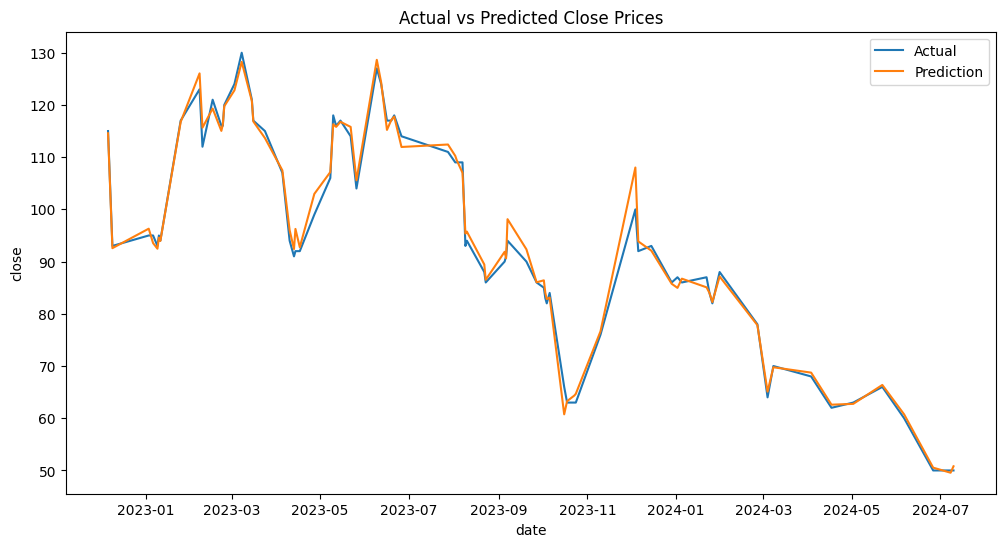

In [14]:
pandas_df = predictions.select("date", "close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="close", data=pandas_df, label="Actual")
sns.lineplot(x="date", y="prediction", data=pandas_df, label="Prediction")
plt.title("Actual vs Predicted Close Prices")
plt.show()